In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd

import sys
sys.path.append('../../tools')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

z = 0.066
t_max = 2458256.9
t_max_mjd = t_max - 2400000.5
ebv = 0.032
rv = 3.1

In [10]:
color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [11]:
import glob

spec_files_0 = glob.glob('../../spectroscopy/SN2018byg/*ascii')
spec_files_0.sort()
spec_files = [s for s in spec_files_0 if not ('20180603' in s)]
spec_He_files = [s for s in spec_files_0 if ('20180603' in s)]

# Compare Lines

In [12]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c * ((lambda_rf / lambda_0)**2 - 1) / ((lambda_rf / lambda_0)**2 + 1)

    return v

In [40]:
def compare_lines(spec_files,
                  ax,
                  line=10830,
                  vmax=-30000,
                  vmin=0,
                  norm_fac=1,
                  bin_size=100,
                  phase_min=-np.inf,
                  phase_max=np.inf,
                  instru=[],
                  phases=[]):
    '''Compare the line regions in velocity space
    '''

    from data_binning import data_binning, plot_box_spec
    from astropy.time import Time

    spec_num = -1
    for k, spec in enumerate(spec_files):
        if 'P60' in spec:
            continue
        with open(spec) as f:
            ll = f.readlines()
        # brute force
        
        phase = phases[k]
        if (phase < phase_min) or (phase > phase_max):
            continue
        spec_df = pd.read_csv(spec,
                              comment='#',
                              delim_whitespace=True,
                              header=None)

        if 'Keck' in spec:
            try:
                fl_unc0 = spec_df[3].values
            except:
                fl_unc0 = spec_df[2].values
        else:
            try:
                fl_unc0 = spec_df[2].values
            except:
                fl_unc0 = np.ones_like(spec_df[1])

            if 'P60' in spec:
                fl_unc0 **= .5

        wv0, fl0 = spec_df[0].values / (1 + z), spec_df[1].values
        E0 = 10**(0.4 * calALambda(wv0, rv, ebv))
        norm = fl0[np.abs(wv0 - 9000) < 500].mean()
        fl0 *= E0 / norm
        fl_unc0 *= E0 / norm
        wv0, fl_unc0 = wv0[~np.isnan(fl0)], fl_unc0[~np.isnan(fl0)]
        fl0 = fl0[~np.isnan(fl0)]
        vel_rf0 = velocity_rf(wv0, line)

        out = data_binning(np.array([vel_rf0, fl0, fl_unc0]).T, size=bin_size)
        if len(out) == 0:
            continue
        out = out[~np.isnan(out[:, 1])]
        vel_rf_bin, fl_bin = plot_box_spec(out[:, 0], out[:, 1])
        vel_rf, fl = plot_box_spec(vel_rf0, fl0)
        fl_unc = np.repeat(fl_unc0, 2)

        if phase < 0:
            label = r'$-{:.0f}\,\mathrm d$'.format(np.abs(phase))
        else:
            label = r'$+{:.0f}\,\mathrm d$'.format(np.abs(phase))
        print(phase)

        spec_num += 1
        h = 0.85
        ax.plot(vel_rf_bin[(vel_rf_bin < vmin) & (vel_rf_bin > vmax)] / 1000,
                np.log10(fl_bin[(vel_rf_bin < vmin) & (vel_rf_bin > vmax)] /
                         norm_fac) - spec_num * h,
                color='0.3',
                linewidth=1.5)
        ax.plot(vel_rf[(vel_rf < vmin) & (vel_rf > vmax)] / 1000,
                np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)] / norm_fac) -
                spec_num * h,
                alpha=0.2,
                color='0.3')
        vm = vel_rf[(vel_rf < vmin) & (vel_rf > vmax)][-1]
        arg = np.abs(vel_rf_bin - vmin + (vmin - vmax) * 0.8) < 5000
        argm = np.argmin(np.abs(vel_rf_bin - vmax))
        if arg.sum() == 0:
            arg = [3, 4]
        ax.text((vmin - (vmin - vmax) * 1.04) / 1000,
                np.log10(np.median(fl_bin[arg]) / norm_fac) -
                (spec_num + 0.1) * h,
                label,
                color='0.3',
                va='top',
                ha='left')
        ax.text((vm - (vm - vmax) * 0.) / 1000,
                np.log10(fl[np.argmin(np.abs(vel_rf - vmin))] / norm_fac) -
                (spec_num + 0.3) * h,
                '${}$'.format(instru[spec_num]),
                color='0.3',
                va='center')
        ax.set_xlim((vmax - (vmin - vmax) * 0.0765) / 1000,
                    (vmin + (vmin - vmax) * 0.2) / 1000)
        ax.set_ylabel(r'$\log F_\lambda+ \mathrm{offset}$')
        #plt.fill_between(vel_rf,
        #                 fl - fl_unc, fl + fl_unc,
        #                 alpha=0.5, color=col[k + displace])
    ax.set_xlabel('$v\ [10^3\ \mathrm{km\,s}^{-1}]$')
    #ax.set_yticks([])

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_99515/357519885.py:50: RuntimeWarning: Mean of empty slice.
  norm = fl0[np.abs(wv0 - 9000) < 500].mean()
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_99515/357519885.py:79: RuntimeWarning: invalid value encountered in log10
  np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)] / norm_fac) -
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_99515/357519885.py:79: RuntimeWarning: invalid value encountered in log10
  np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)] / norm_fac) -
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_99515/357519885.py:74: RuntimeWarning: invalid value encountered in log10
  np.log10(fl_bin[(vel_rf_bin < vmin) & (vel_rf_bin > vmax)] /
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykerne

18
27
15


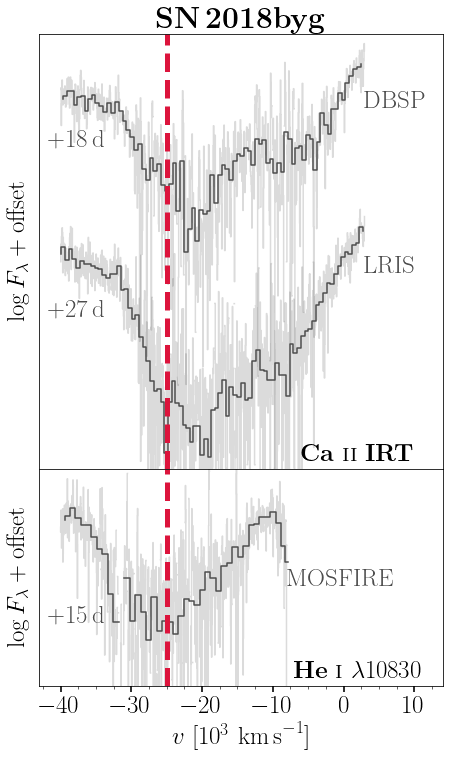

In [41]:
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(nrows=3,
                      ncols=3,
                      left=0.05,
                      right=0.75,
                      hspace=0,
                      wspace=0.05)
ax0 = fig.add_subplot(gs[:-1, :])
ax1 = fig.add_subplot(gs[-1, :])

Ca_II_IRT = (8498.018 + 8542.089 + 8662.140) / 3
instru = [
    r'\mathrm{DBSP}', r'\mathrm{LRIS}'
]
compare_lines(spec_files,
              ax0,
              line=Ca_II_IRT,
              vmax=-40000,
              vmin=3000,
              phase_min=10,
              phase_max=30,
              norm_fac=0.65,
              bin_size=500,
              instru=instru,
              phases=[-10, -5, -2, 8, 11, 18, 27, 52])
ax0.set_ylim(-1.7, 0.5)
ax0.set_xticks([])
ax0.set_xlabel('')
ax0.set_yticks([-1.5, -1, -0.5, 0, 0.5])
ax0.text(2, -1.66, r'$\mathbf{Ca\ \textsc{ii}\ IRT}$', ha='center')

HeI = 10830
instru_He = [r'\mathrm{MOSFIRE}']
compare_lines(spec_He_files,
              ax1,
              line=HeI,
              vmax=-40000,
              vmin=3000,
              phase_min=11,
              phase_max=37,
              norm_fac=1,
              bin_size=750,
              instru=instru_He,
              phases=[15])
ax1.set_ylim(-1.2, 0.4)
ax0.set_yticks([])
ax1.set_yticks([])
#ax1.text(2, -1.15, r'$\mathbf{He\ \textsc{i}\ \lambda 10830}$', ha='center')
ax1.text(2,
         -1.15,
         r'$\mathbf{He\ \textsc{i}}\ \mathrm{\lambda 10830}$',
         ha='center')

ax0.axvline(-25, color='crimson', linestyle='--', linewidth=5)
ax1.axvline(-25, color='crimson', linestyle='--', linewidth=5)
ax1.xaxis.set_minor_locator(MultipleLocator(2.5))
ax1.xaxis.set_major_locator(MultipleLocator(10))

ax0.set_xlim(-43, 14)
ax1.set_xlim(-43, 14)

ax0.set_title('$\mathbf{SN\,2018byg}$')
plt.savefig('CaII_HeI_hvf.pdf', bbox_inches='tight')